In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, fbeta_score, f1_score,
    matthews_corrcoef, balanced_accuracy_score,
    roc_auc_score, average_precision_score, classification_report, confusion_matrix
)
from scikitplot.metrics import plot_roc, plot_confusion_matrix, plot_precision_recall

In [2]:
%load_ext watermark

In [3]:
%watermark -vp numpy,pandas,sklearn,scikitplot,imblearn,lightgbm,matplotlib

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.8.0

numpy     : 1.23.3
pandas    : 1.5.0
sklearn   : 1.2.2
scikitplot: 0.3.7
imblearn  : 0.0
lightgbm  : 3.3.5
matplotlib: 3.7.1



### Data

Simulamos un dataset de clasificación desbalanceado, y separamos un validation set.

In [4]:
X, y = make_classification(
    n_samples=20_000, n_features=4, n_informative=4, n_redundant=0, n_classes=2,
    n_clusters_per_class=1, weights=[0.98, 0.02], flip_y=0.05, class_sep=0.8, 
    random_state=18)

In [5]:
print(y.mean()) # because of flip_y!

0.04345


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=33)

In [7]:
print(y_train.mean())
print(y_val.mean())

0.0435
0.0434


In [8]:
# cómo me fijo cuántos datos tengo de cada clase?

# np.count_nonzero(y == 1)
# y.sum()
# (y == 1).sum()
pd.Series(y).value_counts()

0    19131
1      869
dtype: int64

### Training

Vamos a entrenar un clasificador LightGBM usando hiperparámetros default

**Por el momento**, vamos a suponer que nos interesa optimizar el F2 score. 

Recordemos algunas definiciones:

$$
R = recall = \frac{TP}{P} = 1 - FNR \\
specificity = \frac{TN}{N} = 1 - FPR \\
P = precision = \frac{TP}{P^{est}} \\
F_{\beta} = \frac{(\beta^2 + 1)PR }{\beta^2 P + R}  \\
$$


Vamos a probar tres estrategias para tratar el desbalance -- no son excluyentes!

In [9]:
# NOTE default HPs, no tuning
params = dict(n_jobs=2)

**1. Thresholding**

Nada nuevo: entrenamos un modelo sin modificaciones y buscamos un punto de corte que optimice la métrica.

Como vimos, en general es recomendable tunear un umbral cuando entrenamos modelos de LM (porque los puntajes pueden estar descalibrados + porque el umbral óptimo depende de la métrica que nos interesa optimizar).

In [10]:
clf_base = LGBMClassifier(**params)

In [11]:
%%time
_ = clf_base.fit(X_train, y_train)

CPU times: total: 422 ms
Wall time: 743 ms


In [12]:
def f2_score(y, y_pred, beta=2):
    return fbeta_score(y, y_pred, beta=beta)

def get_proba(clf, X):
    return clf.predict_proba(X)[:, 1]

def metrics_by_threshold(clf, X, y, metric_fn):
    thresholds = np.linspace(0, 1, 100)
    y_pred_proba = get_proba(clf, X)
    metrics = [metric_fn(y, y_pred_proba > t) for t in thresholds]
    return pd.DataFrame({"threshold": thresholds, "metric": metrics})

def plot_metric_by_threshold(clf, X, y, metric_fn):
    df_thresholds = metrics_by_threshold(clf, X, y, metric_fn)
    df_optimal = df_thresholds.loc[df_thresholds["metric"].idxmax()]
    optimal_threshold = df_optimal["threshold"]
    max_metric = df_optimal["metric"]
    # vertical bar at optimal threshold
    plt.axvline(x=optimal_threshold, color="r", linestyle="--")
    plt.axvline(x=0.5, color="gray", linestyle="--")
    plt.plot(df_thresholds["threshold"], df_thresholds["metric"])
    plt.xlim(0,1)
    # change fig size:
    plt.gcf().set_size_inches(5, 3)
    # max value and optimal threshold in the title:
    plt.title(
        f"max {metric_fn.__name__}: {max_metric:.3f} | threshold = {optimal_threshold:.3f}")

def print_metrics(clf, X, y, threshold=.5):
    y_pred_proba = get_proba(clf, X)
    y_pred = y_pred_proba > threshold
    print(f"### threshold = {threshold:.3f}")
    print(f"accuracy: {accuracy_score(y, y_pred):.3f}")
    print(f"f2: {f2_score(y, y_pred):.3f}")
    print(f"roc_auc: {roc_auc_score(y, y_pred_proba):.3f}")

def clf_diagnostic(clf, X, y, metric_fn=f2_score):
    plot_metric_by_threshold(clf, X, y, metric_fn)
    plt.show()
    df_threshold = metrics_by_threshold(clf, X, y, metric_fn)
    threshold = df_threshold.loc[df_threshold["metric"].idxmax()]["threshold"]
    print_metrics(clf, X_val, y_val, threshold)
    print_metrics(clf, X_val, y_val, 0.5)


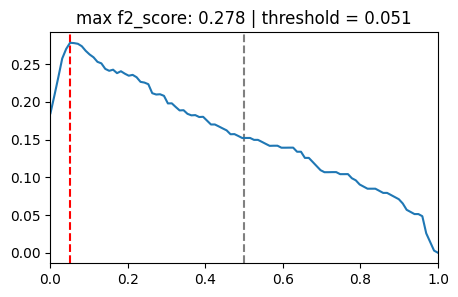

### threshold = 0.051
accuracy: 0.833
f2: 0.278
roc_auc: 0.695
### threshold = 0.500
accuracy: 0.960
f2: 0.152
roc_auc: 0.695


In [13]:
clf_diagnostic(clf_base, X_val, y_val, metric_fn=f2_score)

> * ¿Por qué AUROC da igual en los dos umbrales?
> 
> * Cuando bajamos el umbral, ¿qué pasa con el recall y con la especificidad?
>
> Consigna: hacer la matriz de confusion para el caso en el que predecimos siempre la clase mayoritaria y calcular el accuracy "a mano"

In [14]:
y_val

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
y_pred = np.full_like(y_val, 0)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

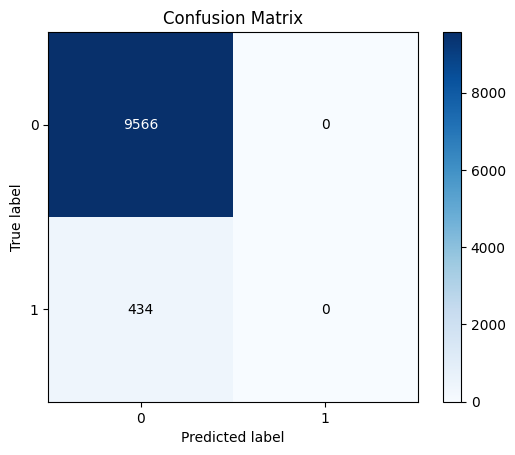

In [16]:
plot_confusion_matrix(y_val, y_pred)
plt.show()

In [17]:
(y_val == 0).mean()

0.9566

In [18]:
9566 / (9566 + 434)

0.9566

**2. Pesos en la función de pérdida**

En general los modelos supervisados optimizan internamente una métrica (función de pérdida o costos). Muchas veces estas métricas admiten ponderadores; es decir, costos diferenciales para cada clase. 

Incrementando el costo del error de clasificación para la clase menos frecuente podríamos ayudar al modelo a que aprenda mejor a clasificarla, y eventualmente a optimizar la métrica que nos interesa.

**Por ejemplo**, para un problema de clasificación con $K$ clases, la _log-loss_ o _cross-entropy_:

$$
- \sum_{c=1}^K y_{c} \log \hat{p}_{c}
$$

se puede modificar con pesos para cada clase: 

$$
- \sum_{c=1}^K w_{c} y_{c} \log \hat{p}_{c}
$$

tal que $w_{c}$ pondera a cada clase inversamente según su frecuencia. En particular, en `sklearn` los pesos se definen de manera tal que las observaciones de cada clase tengan la misma representación en los datos de entrenamiento:


> ¿Cómo se interpreta la log-loss para una observación $i$?


$y = (1, 0)$ 

$\hat{p} = (0.05, 0.95)$ 

$CE = - (1 \cdot \log 0.6 + 0 \cdot \log 0.4 ) = - \log 0.05$

C:\Users\Fran\AppData\Local\Temp\ipykernel_5584\1232268347.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x))


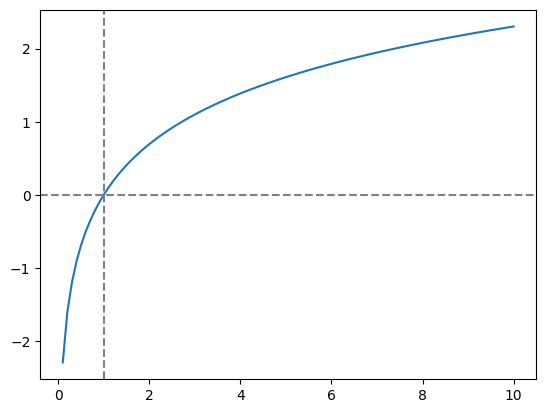

In [19]:
# plot log(x)
x = np.linspace(0, 10, 100)
plt.plot(x, np.log(x))
plt.axvline(x=1, color="gray", linestyle="--")
plt.axhline(y=0, color="gray", linestyle="--")
plt.show()


In [20]:
# ejemplo del cálculo de los ponderadores de clase:
n_samples = X_train.shape[0]
freq_classes = np.bincount(y_train)
n_classes = len(freq_classes)

print("raw frequencies:")
print(freq_classes)

ws = n_samples / (n_classes * freq_classes)
print("class weights:")
print(ws)
print(freq_classes * ws)

raw frequencies:
[9565  435]
class weights:
[ 0.52273915 11.49425287]
[5000. 5000.]


In [21]:
clf_weights = LGBMClassifier(is_unbalance=True, **params)
# NOTE para custom class weights, usar scale_pos_weight
# (https://github.com/microsoft/LightGBM/issues/1299#issuecomment-379179552)

In [22]:
%%time
_ = clf_weights.fit(X_train, y_train)

CPU times: total: 250 ms
Wall time: 707 ms


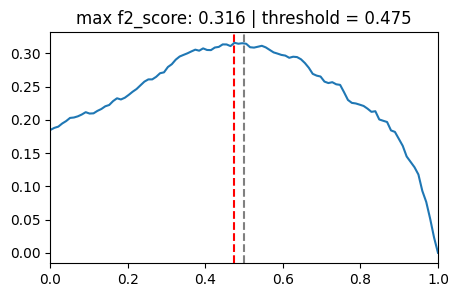

### threshold = 0.475
accuracy: 0.890
f2: 0.316
roc_auc: 0.696
### threshold = 0.500
accuracy: 0.900
f2: 0.312
roc_auc: 0.696


In [23]:
clf_diagnostic(clf_weights, X_val, y_val)

Vean que hacer esto equivale a balancear los datos de entrenamiento, pero sin modificarlos! 

Estamos alterando la "probabilidad baseline" de cada clase ("priors") -- por eso cambia tanto el punto de corte (más sobre esto más abajo).

**3. Resampling**

En lugar de modificar la función de pérdida, hay mútliples estrategias que remuestrean los datos de entrenamiento de manera tal que las clases tengan la misma frecuencia. 

La estrategia más simple es la de **random over-sampling**. 

Pueden revisar otras estrategias más sofisticadas en la [guía de `imblearn`](https://imbalanced-learn.org/stable/user_guide.html).

In [24]:
clf_ros = Pipeline([
    ('ros', RandomOverSampler(random_state=0)),
    ('clf', LGBMClassifier(**params)),
])

In [25]:
%%time
_ = clf_ros.fit(X_train, y_train)

CPU times: total: 469 ms
Wall time: 620 ms


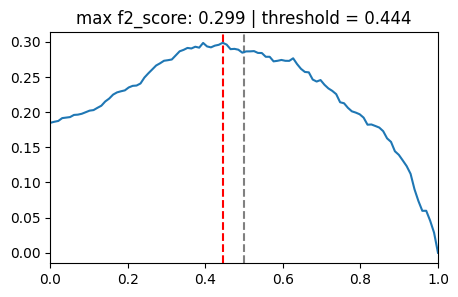

### threshold = 0.444
accuracy: 0.874
f2: 0.299
roc_auc: 0.691
### threshold = 0.500
accuracy: 0.902
f2: 0.287
roc_auc: 0.691


In [26]:
clf_diagnostic(clf_ros, X_val, y_val)

En general es mucho más eficiente y prolijo modificar la función de pérdida que resamplear los datos. 

En cualquier caso, siempre podemos evaluar cuál funciona mejor para nuestro problema --> mirando el rendimiento en el validation set :)

### Distribuciones de los scores

¡**OJO** con la escala de las predicciones! Puede ser importante conservar la interpretación de probabilidad de los scores, que con algunas estrategias se pierde...

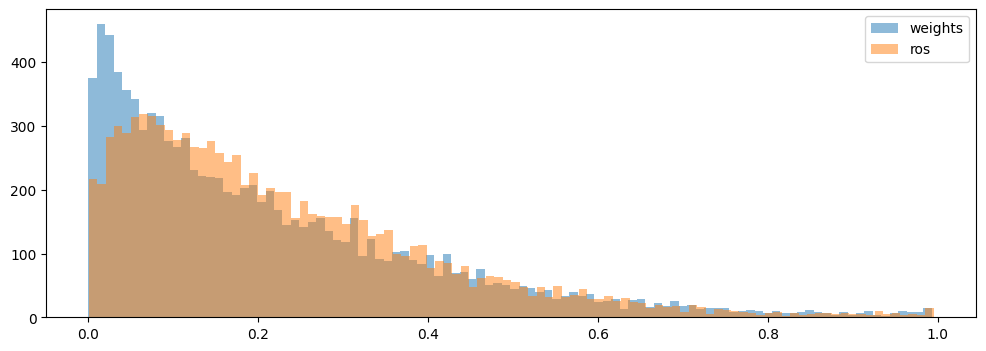

In [27]:
# density distribution of predictions of the 3 models
fig, ax = plt.subplots(figsize=(12, 4))
# ax.hist(get_proba(clf_base, X_val), bins=100, label="base", alpha=.5)
ax.hist(get_proba(clf_weights, X_val), bins=100, label="weights", alpha=.5)
ax.hist(get_proba(clf_ros, X_val), bins=100, label="ros", alpha=.5)
plt.legend()
plt.show()

### Métricas de performance

Vamos a conservar el modelo que usa _class weights_ con un threshold de 0.5 y analizar el comportamiento de distintas métricas de performance. 

**Nunca olvidar que la elección de métrica depende del problema!**

In [29]:
# usamos el modelo con class weights
y_val_pred_proba = clf_weights.predict_proba(X_val)[:, 1]
y_val_pred = y_val_pred_proba > 0.5

#### Bondad global del modelo

In [40]:
print(y_val, y_val_pred_proba)

[0 0 0 ... 0 0 0] [0.09139024 0.31741839 0.10266064 ... 0.19504086 0.30843852 0.37276052]


In [30]:
print(f"AUROC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")

AUROC: 0.6964


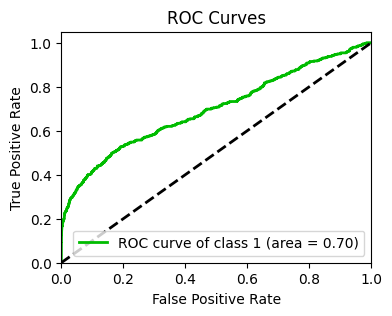

In [31]:
# plot the ROC curve
y_pred_ = clf_weights.predict_proba(X_val)
plot_roc(y_val, y_pred_, classes_to_plot=[1], plot_micro=False, plot_macro=False)
plt.gcf().set_size_inches(4, 3)
plt.show()
# NOTE exije las 2 columnas

AUROC es **simétrica** e **insensible al desbalance**. 

Esto es porque

1. Pondera a las dos clases por igual,
2. En datos desbalanceados (pocos positivos), $TN$ tiene un peso grande y la $FPR$ tiende a quedarse en valores bajos, lo cual la vuelve poco informativa ($FPR = FP / (FP + TN)$). Puede haber cambios sensibles en la precisión no capturados por FPR -- por ejemplo:

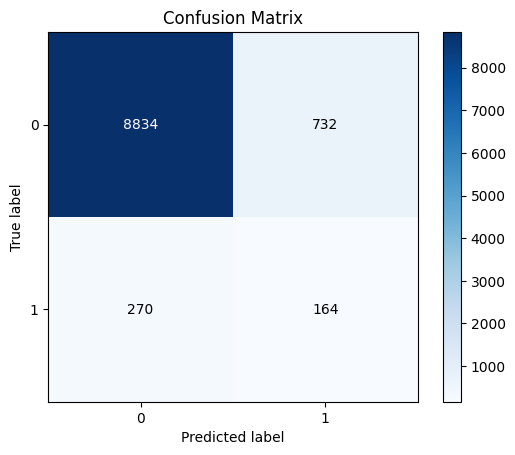

In [32]:
plot_confusion_matrix(y_val, y_val_pred, normalize=False)
plt.show()

In [33]:
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
print(f"precision = {tp / (tp + fp):.4f}")
print(f"FPR = {fp / (fp + tn):.4f}")

precision = 0.1830
FPR = 0.0765


In [35]:
# modelo que reduce en 100 los falsos positivos
tp_ = tp + 100
fp_ = fp - 100
tn_ = tn + 100
fn_ = fn - 100
print(f"precision = {tp_ / (tp_ + fp_):.4f}")
print(f"FPR = {fp_ / (fp_ + tn_):.4f}")

precision = 0.2946
FPR = 0.0661


La precision cambió sensiblemente pero FPR no captura esto! 

AUROC evalúa FPR (bondad para captar negativos) y TNR (bondad para captar positivos) "por separado" y con la misma ponderación. Por eso es **simétrica**: si invertimos la codificación del target, el resultado es el mismo.

Si queremos una métrica _global_ para el caso en el que los positivos son más importantes (los movimientos en los FP son importantes) podemos usar el **Area Under the Precision-Recall Curve** (AUPRC) de la clase que nos interesa: en lugar de mirar recall y especificidad, mira recall y precision.

Sobre todo en datasets desbalanceados, dos modelos pueden tener AUROC similar pero muy distinta AUPRC! Vean por ejemplo [este post](https://sinyi-chou.github.io/).

In [36]:
print(f"AUPRC: {average_precision_score(y_val, y_val_pred_proba):.3f}")

AUPRC: 0.274


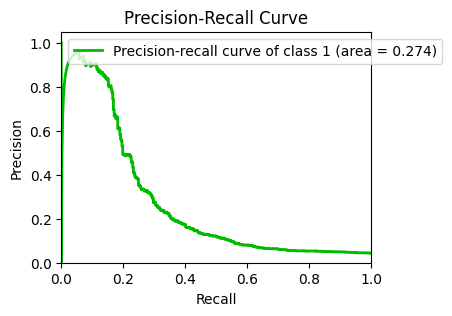

In [37]:
y_pred_ = clf_weights.predict_proba(X_val)
plot_precision_recall(y_val, y_pred_, classes_to_plot=[1], plot_micro=False,)
plt.gcf().set_size_inches(4, 3)
plt.show()

Tengan en cuenta que, a diferencia de AUROC, los valores de AUPRC dependen _mucho_ de la distribución del target, de modo que modelos de datasets con distinta distribución de clases no son inmediatamente comparables.

#### Métricas de clasificación

Ya sabemos que accuracy es poco informativa en datos desbalanceados.

Si el problema es **asimétrico** (nos interesan más los positivos que los negativos), podemos usar el F-score.

In [42]:
print(y_val, y_val_pred.astype(int))

[0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0]


In [39]:
print(
    classification_report(y_val, y_val_pred, labels=clf_weights.classes_))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      9566
           1       0.18      0.38      0.25       434

    accuracy                           0.90     10000
   macro avg       0.58      0.65      0.60     10000
weighted avg       0.94      0.90      0.92     10000



Para problemas **simétricos** (me interesan las dos clases por igual) con datos desbalanceados podemos usar:

* **Balanced accuracy**: es el promedio simple del _recall_ de cada clase (en el caso binario es el promedio simple de la _sensibilidad_ y la _especificidad_; extensible a $K$ clases).

* **Macro F1**: es el promedio simple de los F1 de cada clase (extensible a $K$ clases, como veremos la clase que viene).

* **MCC** (Matthews Correlation Coefficient): es **muy** parecido a la V de Cramér (para el caso binario)! +1 indica una clasificación perfecta, 0 una predicción random y -1 una predicción invertida. Más detalles [acá](https://en.wikipedia.org/wiki/Phi_coefficient#Machine_learning). 

In [50]:
print(f"Balanced accuracy = {balanced_accuracy_score(y_val, y_val_pred):.4f}")
print(f"Macro F1 = {f1_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"MCC = {matthews_corrcoef(y_val, y_val_pred):.4f}")
print("-" * 20)
print(f"Accuracy = {accuracy_score(y_val, y_val_pred):.4f}")

Balanced accuracy = 0.6507
Macro F1 = 0.5965
MCC = 0.2150
--------------------
Accuracy = 0.8998


-----------------------

Resumiendo:

* Métricas "globales" (evalúan los scores / la capacidad potencial de clasificar / la capacidad de separar/discriminar las clases)
    * auroc (simétrico)
    * auprc (asimétrico)
* Métricas de clf (evalúan la clasificación)
    * accuracy (simétrico y balanceados)
    * $F_\beta$ score (asimétrico)
    * macro-F1, MCC, balanced accuracy (simétrico y desbalanceado)
    * función de costos (métrica genérica)

--------------------------------------

Sugerimos que entiendan las métricas analizando cómo se comporta cada una frente a un modelo _tonto_ (predice siempre la clase mayoritaria o que hace una predicción _random_).

Esto es muy útil también en problemas reales para tener valores de referencia. Siempre en general es recomendable tener benchmarks (puede ser un modelo random, ingenuo, rápido de correr, etc., depende del objetivo).

In [47]:
# el modelo mas simple:
y_majority = pd.Series(y_train).value_counts().index[0]
y_val_pred_0 = np.full_like(y_val, y_majority)

# el modelo mas tonto:
y_val_pred_proba_dummy = np.random.uniform(size=y_val.shape)
y_val_pred_dummy = (y_val_pred_proba_dummy > 0.5).astype(int)

# un modelo que predice segun los priors de las clases:
y_val_pred_proba_prior = np.random.choice([0, 1], size=y_val.shape, p=[y_train.mean(), 1 - y_train.mean()])